In [2]:
import numpy as np
from commpy.channels import awgn
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
import pandas as pd
from pyMRI.utils import RMSE

In [3]:
metabolites = pymri.METABOLITES
met_i = 1

t0, tn, dt, B0 = pymri.setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = pymri.unpack_metabolites(metabolites, B0)
ws, t2s, M_0s = ws[met_i - 1:met_i], t2s[met_i - 1:met_i], M_0s[met_i - 1:met_i]

spins_phi = np.zeros_like(M_0s)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")

All frequencies are captured by the sampling rate.


In [4]:
sigma = 0.01

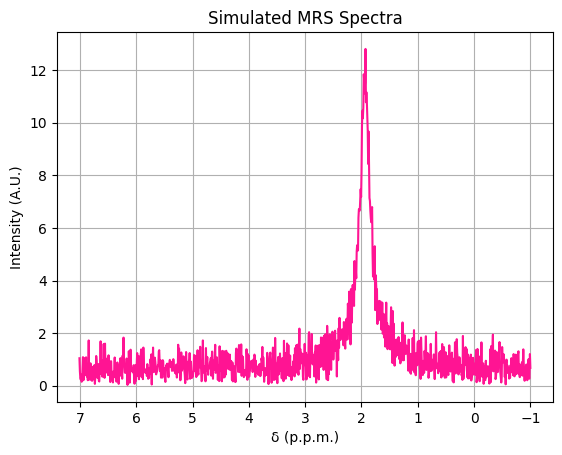

In [5]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay( t0, tn, dt, pop, np.array([]) )
freqs, sig_fft = pymri.fourier_spectrum( sig, dt, B0 )

c_sig_fft = awgn(sig_fft, 5.0)
c_sig  = np.fft.ifft(np.fft.ifftshift(c_sig_fft))

pymri.plot_chem_shifts( freqs, c_sig_fft, 1.0 )

In [6]:
L = 0.4
noise_threshold = 1e-30

In [7]:
reconstructed_sig, z, r = pymri.filter_sig(c_sig, L, noise_threshold, return_poles_and_res=True)

In [8]:
s0, phi, omega, alpha = pymri.calculate_variables_from_z_and_r(z, r, dt)
t2 = 1/alpha

In [9]:
# n_comp = 10

# sort_arr = np.argsort(s0)
# s0_ = s0[sort_arr]
# phi_ = phi[sort_arr]
# omega_ = omega[sort_arr]
# t2_ = t2[sort_arr]

# s0_ = s0_[s0.size - n_comp:]
# phi_ = phi_[phi.size - n_comp:]
# omega_ = omega_[omega.size - n_comp:]
# t2_ = t2_[t2.size - n_comp:]

# print(t2_.size)

In [10]:
def select_peaks(s0 : np.ndarray,
                 phi : np.ndarray,
                 omega : np.ndarray,
                 t2 : np.ndarray, 
                 percentage : float = 0.1):
    """Calculates the peaks to be individually analysed, based on the highest peak value of `s0`. 
    Peaks below `percentage*highest_peak` will be discarded.
    
    Parameters
    ----------
    s0 : np.ndarray
        Peaks array.
    phi : np.ndarray
        Phases array.
    omega : np.ndarray
        Frequencies array.
    t2 : np.ndarray
        Decaying time T_2 array.
    percentage : float = `0.1`
        The percentage of the peak that will be used to filter. Default is `0.1`."""
    
    sort_arr = np.argsort(s0)

    s0_ = s0[sort_arr]
    phi_ = phi[sort_arr]
    omega_ = omega[sort_arr]
    t2_ = t2[sort_arr]

    peak = s0_[-1]

    s0__ = s0_[s0_ >= percentage*peak]
    phi__ = phi_[s0_ >= percentage*peak]
    omega__ = omega_[s0_ >= percentage*peak]
    t2__ = t2_[s0_ >= percentage*peak]

    n_comp = s0__.size

    return s0__, phi__, omega__, t2__, n_comp


In [11]:
s0_, phi_, omega_, t2_, n_comp = select_peaks(s0, phi, omega, t2, 0.3)

individual_sigs = np.zeros((n_comp, sig.size), dtype=np.complex128)

sig_fft_i = np.zeros((n_comp, sig_fft.size), dtype=np.complex128)
freqs_i = np.zeros((n_comp, freqs.size))

In [12]:
for i in range(n_comp):
    pop = pymri.population(np.array([omega_[i]]), np.array([t2_[i]]), np.array([s0_[i]]), np.array([phi_[i]]))
    individual_sigs[i] = pymri.population_transverse_decay(t0, tn, dt, pop)[0]
    freqs_i[i], sig_fft_i[i] = pymri.fourier_spectrum( individual_sigs[i], dt, B0)
    

In [13]:
final_sig = np.sum(individual_sigs, axis = 0)
freqs_, sig_fft_ = pymri.fourier_spectrum(final_sig, dt, B0)

In [14]:
import matplotlib.colors as mcolors
colors = list(mcolors.CSS4_COLORS)

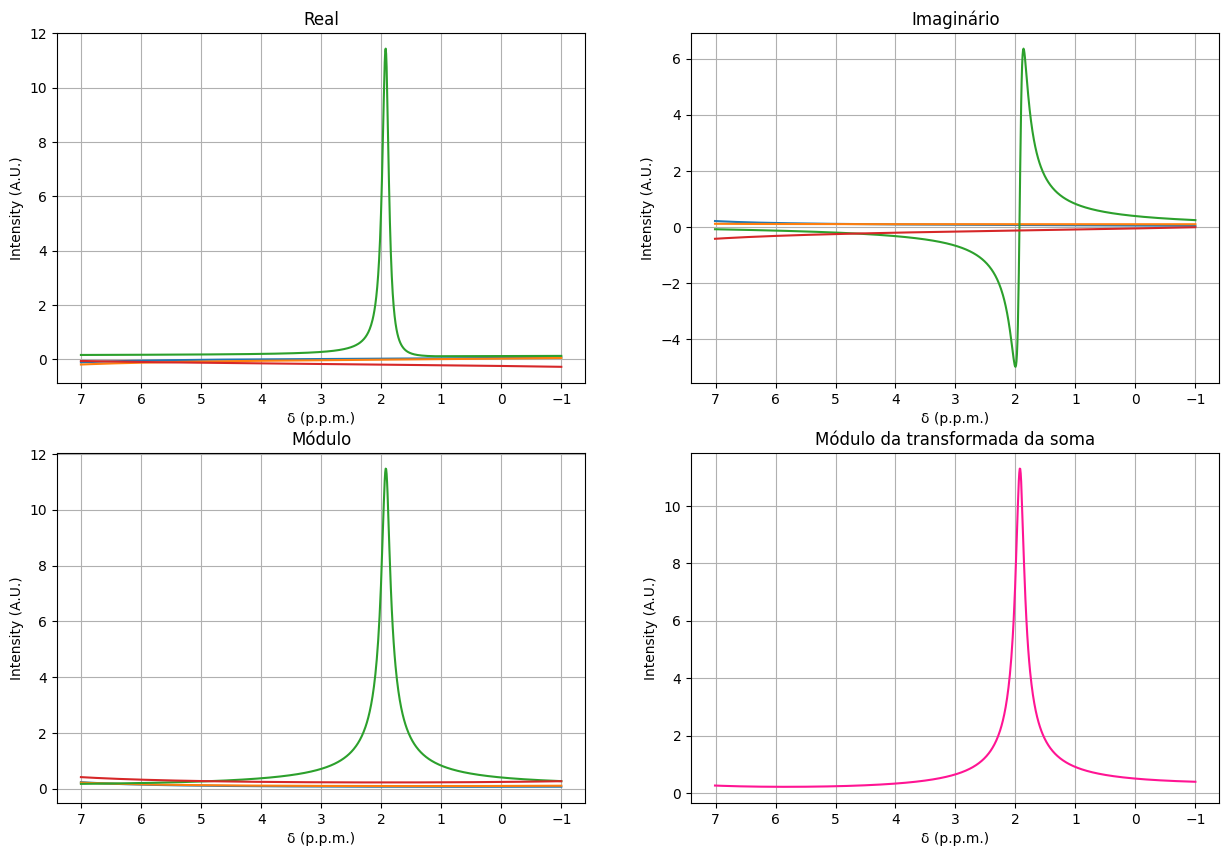

In [15]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
for i in range(n_comp): 
    pymri.plot_chem_shifts(freqs_i[i], sig_fft_i[i], 1.0, c = None, plot_type="real", title= "Real", label=f"{n_comp - i} maior")

plt.subplot(222)
for i in range(n_comp): 
    pymri.plot_chem_shifts(freqs_i[i], sig_fft_i[i], 1.0, c = None, plot_type="imag", title="Imaginário", label=f"{n_comp - i} maior")

plt.subplot(223)
for i in range(n_comp): 
    pymri.plot_chem_shifts(freqs_i[i], sig_fft_i[i], 1.0, c = None, plot_type="abs", title="Módulo", label=f"{n_comp - i} maior")

plt.subplot(224)
pymri.plot_chem_shifts(freqs_, sig_fft_, 1.0, title = "Módulo da transformada da soma", label = "")

## Number of peaks

In [16]:
rerun = True
filename_end = "_5"
folder_name = "files/"

In [17]:
snrs = np.array([1.0, 2.5, 5.0, 7.5, 10.0, 12.5, 25.0, 37.50, 50.0, 62.50, 75.0, 87.50, 100.0])

In [18]:
n_avgs = 50
n_peaks = np.zeros((n_avgs, snrs.size), dtype=int)
rmse = np.zeros((n_avgs, snrs.size))

In [19]:
def find_interval(arr : np.ndarray, value : float, radius : float, return_indexes : bool = True):
    """Finds the interval, defined by `[value - radius : value + radius]`, of a given ordenated array.
    
    Parameters
    ----------
    
    arr : np.ndarray
        The ordenated array to have the interval found.
    value : float
        The center value of the interval.
    radius : float
        The radius that defines the boundaries of the interval.
    return_indexes : bool = `True`
        Whether to return or not the indexes of the lower and upper boundaries in the array. Default is `True`"""
    assert arr[0] <= value < arr[-1], "Value must be inside the signal's interval."
    assert arr[0] <= value + radius < arr[-1], "Value + radius must be inside the signal's interval."
    assert arr[0] <= value - radius < arr[-1], "Value - radius must be inside the signal's interval."

    diff = np.abs(arr - (value - radius))
    i = np.argmin(diff)

    diff = np.abs(arr - (value + radius))
    j = np.argmin(diff)

    if return_indexes == False:
        return arr[i : j]
    else:
        return arr[i : j], i, j

In [20]:
_, x, y = find_interval(freqs, pymri.chem_shift_from_f(pymri.rad_to_hz(ws[0]), B0), 1.2)

peak_rmse = np.zeros((n_avgs, snrs.size))

In [21]:
if rerun == True:
    for i in range(n_avgs):
        for j in range(snrs.size):

            c_sig_fft = awgn(sig_fft, snrs[j])
            c_sig  = np.fft.ifft(np.fft.ifftshift(c_sig_fft))

            r_sig, z, r = pymri.filter_sig(c_sig, L, noise_threshold, return_poles_and_res=True, return_full_arrays=True)
            s0_, phi_, omega_, t2_ = pymri.calculate_variables_from_z_and_r(z, r, dt)
            t2_ = 1/t2_
            s0__, phi__, omega__, t2__, n_peaks[i, j] = select_peaks(s0_, phi_, omega_, t2_, 0.05)


            r_sig, t_ = pymri.population_transverse_decay(t0, tn, dt, pymri.population(omega__, t2__, s0__, phi__))

            rmse[i, j] = RMSE(np.abs(c_sig), np.abs(r_sig))
            peak_rmse[i, j] = RMSE(np.abs(c_sig[x:y]), np.abs(r_sig[x:y]))

KeyboardInterrupt: 

In [ ]:
subfolder_name = "spec_comp/"
if rerun == True:
    file = open(folder_name + subfolder_name + "n_peaks" + filename_end + ".csv", "w")
    file.write(",".join(f'{x:.16f}' for x in snrs) + "\n")
    for i in range(n_avgs):
        file.write(",".join(str(x) for x in n_peaks[i, :]) + "\n")
    file.close()

    file = open(folder_name + subfolder_name + "rmse" + filename_end + ".csv", "w")
    file.write(",".join(f'{x:.16f}' for x in snrs) + "\n")
    for i in range(n_avgs):
        file.write(",".join(str(x) for x in rmse[i, :]) + "\n")
    file.close()

    file = open(folder_name + subfolder_name + "peak_rmse" + filename_end + ".csv", "w")
    file.write(",".join(f'{x:.16f}' for x in snrs) + "\n")
    for i in range(n_avgs):
        file.write(",".join(str(x) for x in peak_rmse[i, :]) + "\n")
    file.close()

In [ ]:
# If simulation is lost
if(rerun == False):
    file_in = pd.read_csv(folder_name + subfolder_name + "n_peaks" + filename_end + ".csv")

    snrs = file_in.keys().to_numpy(dtype=np.float64)
    n_peaks = file_in.values

    file_in = pd.read_csv(folder_name + subfolder_name + "rmse" + filename_end + ".csv")
    rmse = file_in.values

    file_in = pd.read_csv(folder_name + subfolder_name + "peak_rmse" + filename_end + ".csv")
    peak_rmse = file_in.values

In [ ]:
avg_n_peaks = np.average(n_peaks, axis = 0)
std_n_peaks = np.std(n_peaks, axis = 0)

avg_rmse = np.average(rmse, axis = 0)
std_rmse = np.std(rmse, axis = 0)

avg_peak_rmse = np.average(peak_rmse, axis = 0)
std_peak_rmse = np.std(peak_rmse, axis = 0)

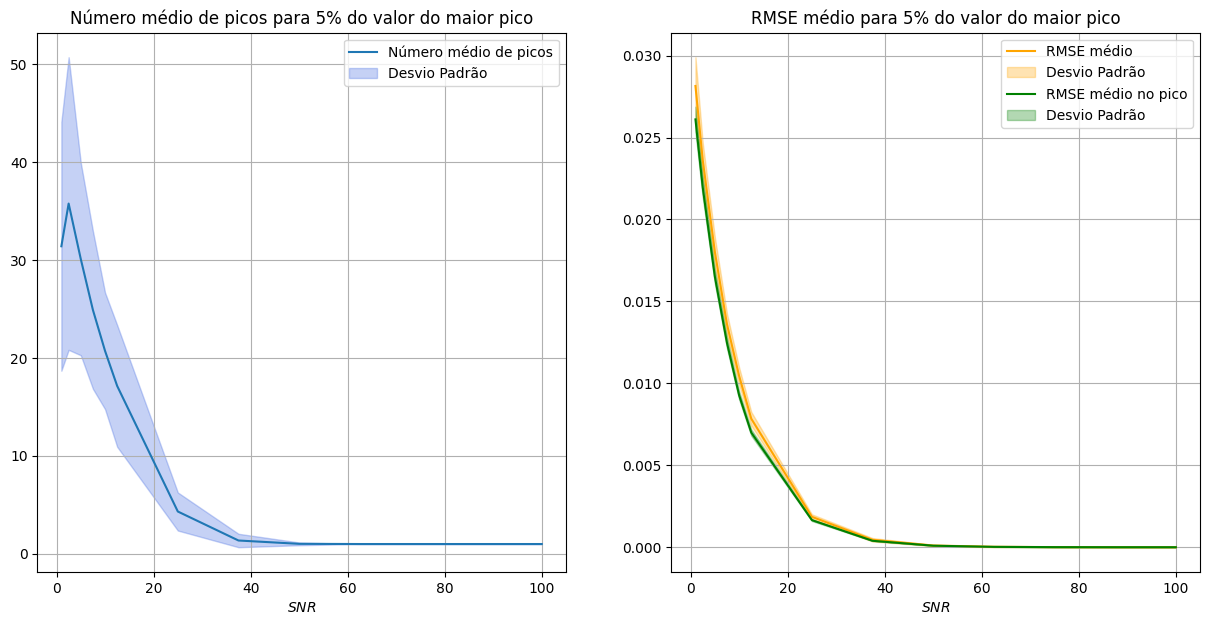

In [ ]:

plt.rcParams.update({'font.size': 16})


plt.figure(figsize=(15, 7))

plt.subplot(121)
plt.title("Número médio de picos para 5% do valor do maior pico")
plt.plot(snrs, avg_n_peaks, label = "Número médio de picos")
plt.fill_between(snrs, avg_n_peaks - std_n_peaks, avg_n_peaks + std_n_peaks, alpha = 0.3, color = "royalblue", label = "Desvio Padrão")
plt.xlabel(r"$SNR$")
plt.legend()
plt.grid()

plt.subplot(122)
plt.title("RMSE médio para 5% do valor do maior pico")
plt.plot(snrs, avg_rmse, label = "RMSE médio", c = "orange")
plt.fill_between(snrs, avg_rmse - std_rmse, avg_rmse + std_rmse, alpha = 0.3, color = "orange", label = "Desvio Padrão")

plt.plot(snrs, avg_peak_rmse, label = "RMSE médio no pico", c = "green")
plt.fill_between(snrs, avg_peak_rmse - std_peak_rmse, avg_peak_rmse + std_peak_rmse, alpha = 0.3, color = "green", label = "Desvio Padrão")
plt.xlabel(r"$SNR$")
# plt.ylabel(r"$n$")
plt.legend()
plt.grid()

In [ ]:
i = 5

sigma_ = pymri.snr_to_sigma(500)
print(sigma_)

_c_sig = pymri.corrupted_snr(sig, 0.0, sigma_)
_c_freqs, _c_sig_fft = pymri.fourier_spectrum( _c_sig, dt, B0 )

0.015359060873968974


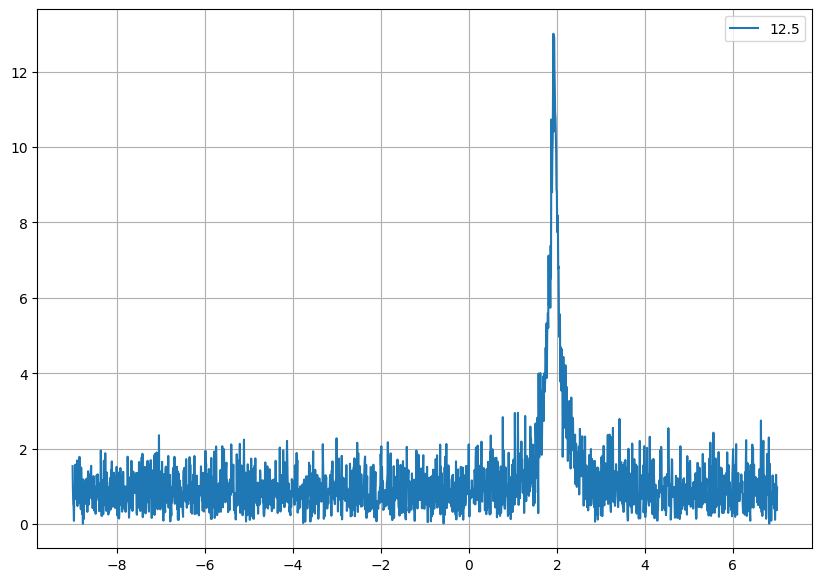

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(_c_freqs, np.abs(_c_sig_fft), label = f"{snrs[i]}")
plt.legend()
plt.grid()